## TensorFlow2官方图像教程：
### 图像分类（Image classification）（笔者翻译）
https://www.tensorflow.org/tutorials/images/classification

#### 目录
1. 引言
> * 导入`TensorFlow`和其他库
> * 下载和探索数据集
2. 使用`keras.preprocessing`加载数据
> * 生成数据集
> * 可视化数据
> * 为实验配置数据集
> * 归一化数据
3. 创建模型
> * 编译模型
> * 模型概要
> * 训练模型
> * 可视化训练结果
4. 改进模型
> * 过拟合
> * 数据增广
> * Dropout
> * 编译训练新改进模型
> * 可视化训练结果
> * 预测新数据

#### 引言
该教程将展示如何对flowers数据集进行图像分类。其使用`keras.Sequential`构建模型从而生成一个图片分类器，并且使用`preprocessing.image_dataset_from_directory`API进行数据的加载。您将通过以下概念获得实践经验：
* 有效的从磁盘加载数据集
* 辨别过拟合并且运用技巧将其减缓，其中包括数据增广和Dropout

该教程遵循机器学习的基本工作流程：
1. 检查和理解数据
2. 构建输入pipeline
3. 构建模型
4. 训练模型
5. 测试模型
6. 改进模型和重复该流程

#### 导入TensorFlow以及其他库

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#### 下载并研究数据集

该教程使用包含3700张花卉图片的数据集，该数据集包含5个子目录，每个目录对应一个子类。
```python
--flower_photo/
  |__daisy/
  |__dandelion/
  |__roses/
  |__sunflowers/
  |__tulips/
```

In [4]:
import pathlib

# 笔者下载本地当前文件夹下
data_dir = "./datasets/flower_photos/" # 数据集文件路径
data_dir = pathlib.Path(data_dir) # 字符串路径转为pathlib.Path对象

# 查看图片数据数量
image_count = len(list(data_dir.glob('*/*.jpg'))) # 查看数据集文件夹下所有jpg图片的数量
print(image_count)

3670


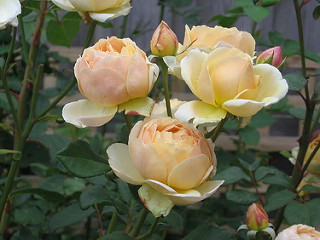

In [5]:
# 查看玫瑰花图片
roses = list(data_dir.glob('roses/*'))
np.random.shuffle(roses)
PIL.Image.open(str(roses[0])) # 查看第一张rose图片

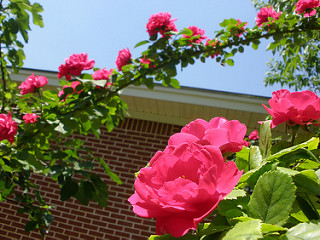

In [6]:
# 查看第二张rose图片
PIL.Image.open(str(roses[1]))

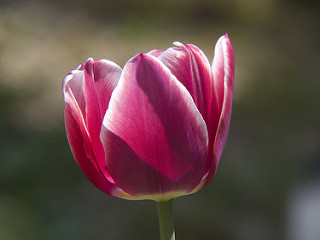

In [11]:
# 查看郁金香图片
tulips = list(data_dir.glob('tulips/*')) # 获取的每个元素均为Path对象
np.random.shuffle(tulips) # 随机打乱
PIL.Image.open(str(tulips[0])) # 由于路径为Path对象因此将其str化

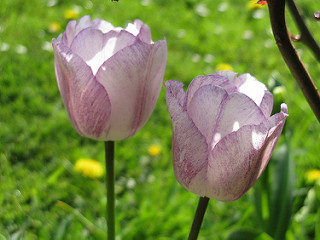

In [12]:
# 查看第二张tulip图片
PIL.Image.open(str(tulips[1]))

#### 使用`keras.preprocessing`加载数据
使用有用的[image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)工具将数据从磁盘中进行加载。仅仅需要几行代码就能让你将磁盘文件夹中的图片数据加载为`tf.data.Dataset`数据。当然，您也可以通过学习该教程：`https://www.tensorflow.org/tutorials/load_data/images`从零开始将图片写进数据加载器中。

In [17]:
# 生成dataset，定义loader的参数
data_dir = "./datasets/flower_photos/" # 数据集文件路径

batch_size = 16
img_height = 180
img_width = 180

# 将图片数据按照8:2进行划分训练集合验证集
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=123, # 随机种子，设置相同序列
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


#### Episode:
* error1:

`AttributeError: module 'tensorflow_core.keras.preprocessing' has no attribute 'image_dataset_from_directory'`

笔者环境:`tf2.1.0`，由于该API比较特殊，在tf2.1.0及以下版本中不存在，因此需要`pip install tf-nightly`版本进行获取合法使用。

* error2:

`TypeError: listdir: illegal type for path parameter`

因为教程中的`data_dir`是Path对象，在读取时不符合`listdir()`函数中的参数类型要求，因此在此之前将`data_dir`设为`str`类型即可。

In [18]:
# 将图片数据按照8:2进行划分训练集合验证集
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="validation",
    seed=123, # 随机种子，设置相同序列
    image_size=(img_height, img_width), # resize图片数据
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [19]:
# 在数据集中的data_names属性中查看类别名称
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### 验证数据

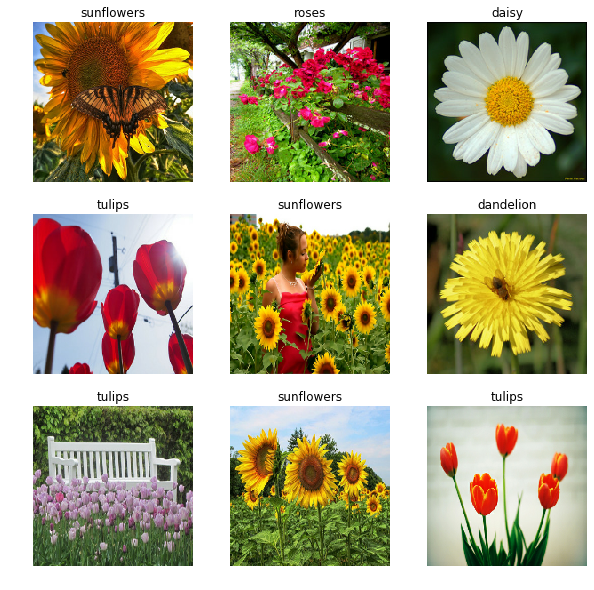

In [21]:
# 从训练集中查看前9张图片
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # 拿一个batch
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

您可以通过使用`model.fit`对刚才创建的数据集进行训练，如果愿意，同样也可以手动的迭代数据集进行按batch训练，如下：

In [22]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print(np.max(image_batch[0]))

(16, 180, 180, 3)
(16,)
247.10173


由上可知，`image_batch`是维度为(16, 180, 180, 3)的张量。即一个`batch`包含16张`180x180x3`的RGB图片。`labels_batch`是(16,)的张量，对应于16张图片的标签。

同时可以使用`.numpy`将`image_batch`和`labels_batch`转为`np.ndarray`类型。

#### 为实验配置数据集
让我们确保使用缓冲预取，这样您就可以从磁盘生成数据，而不会使I/O阻塞。通常在加载数据时有两个方法作为参考：
* 在第一个epoch中将数据加载到磁盘后，`Dataset.cache()`能够将这些图片数据保持在内存中。这可以确保模型训练过程中数据集不会造成堵塞，当然如果数据集过于庞大而无法放进内存时，也可以使用此方法创建一个高性能的磁盘缓存。
* `Dataset.prefetch()`可以在训练过程中将数据预处理和模型执行进行重叠。感兴趣的读者可以通过该教程：[prefetching](https://www.tensorflow.org/guide/data_performance#prefetching)，进行学习数据的加载缓存。

In [23]:
# 设置参数
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### 数据归一化(标准化)
RGB图片通道值在[0,255]范围内，这对于神经网络来说并不是一个理想值，通常我们需要将输入的值设的更小，为了将数据进行归一化，我们使用`Rescaling`层对其进行标准化到[0,1].

In [24]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

# 使用map函数对训练集的像素值进行归一化
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


我们可以通过这种方法将其部署到模型中，能够在训练模型之前轻易的对数据进行归一化。

#### 创建模型
该模型包含了3个卷积层且与最大池化交叉使用。在模型的顶部有一个含128个神经元的全连接层，其激活函数为`relu`。该模型已经被调整到高精度，该教程的目标就是展示一个标准的方法过程。

In [25]:
# 最终类别
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### 编译模型
优化器使用`optimizers.Adam`，损失函数使用`losses.SparseCategoricalCrossentropy`。为了在每一个epoch中展示训练集和验证集准确率，使用`metrics`参数。

In [26]:
# 编译模型
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### 模型概要

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

#### 训练模型

In [28]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
184/184 [==============================] - 83s 453ms/step - loss: 1.2278 - accuracy: 0.4816 - val_accuracy: 0.5654 - val_loss: 1.0646
Epoch 2/10
184/184 [==============================] - 55s 301ms/step - loss: 0.9322 - accuracy: 0.6325 - val_accuracy: 0.6349 - val_loss: 0.9102
Epoch 3/10
184/184 [==============================] - 55s 297ms/step - loss: 0.7393 - accuracy: 0.7279 - val_accuracy: 0.6744 - val_loss: 0.8477
Epoch 4/10
184/184 [==============================] - 56s 306ms/step - loss: 0.5113 - accuracy: 0.8099 - val_accuracy: 0.6662 - val_loss: 0.8650
Epoch 5/10
184/184 [==============================] - 58s 316ms/step - loss: 0.2738 - accuracy: 0.9012 - val_accuracy: 0.6553 - val_loss: 1.0076
Epoch 6/10
184/184 [==============================] - 58s 316ms/step - loss: 0.1202 - accuracy: 0.9625 - val_accuracy: 0.6608 - val_loss: 1.3881
Epoch 7/10
184/184 [==============================] - 59s 321ms/step - loss: 0.0673 - accuracy: 0.9823 - val_accuracy: 0.6485 - va

#### 可视化训练结果

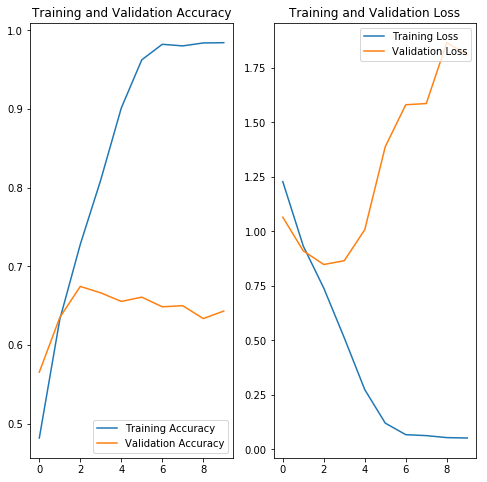

In [30]:
# 对准确率和loss值进行曲线图展示
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

从图中可以看出，训练准确率和验证准确率有着巨大的差距，并且该模型在验证集上只达到60%的准确率。

接下来让我们一起看看问题出现在哪里并对其进行改进提升。

#### 过拟合
上图显示，训练集准确率随着时间线性增长，然而验证集准确率在训练后期仍然徘徊在60%。并且两者准确率的差距是显而易见的，这是[过拟合](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)的一个标志。

当训练样本较少时，模型有可能会从图片的噪声和并非我们想要的细节汇总学习信息，在模型遇到新的样本时这在很大程度上会消极形象其性能。该现象即过拟合，这意味着模型在新的数据上很难泛化。

这里有多种方法用于在训练过程中消除过拟合，此教程中主要有数据增广和`Dropout`。

#### 数据增广
过拟合通常发生在训练样本数量过少时。数据增广是一种通过现有的数据进行增广生成额外的训练数据的方法，主要通过随机的转换方法生成`believable-looking`的图片。这有助于将模型暴露给数据的各方面并得到更好的泛化。

可以使用`Keras Preprocessing Layers`实现对数据的增广。它和其他层一样可以融合进模型中，并且跑在GPU中

In [31]:
data_augmentation = keras.Sequential(
  [
    # 随机翻转
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    # 随机旋转
    layers.experimental.preprocessing.RandomRotation(0.1),
    # 随机缩放
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [32]:
# test code 查看数据基本信息
for images, _ in train_ds.take(1):
    print(images.shape)
print(images.shape)
a_img = data_augmentation(images)
print(a_img.shape)

(16, 180, 180, 3)
(16, 180, 180, 3)
(16, 180, 180, 3)


让我们瞧一瞧样本的数据增广效果：

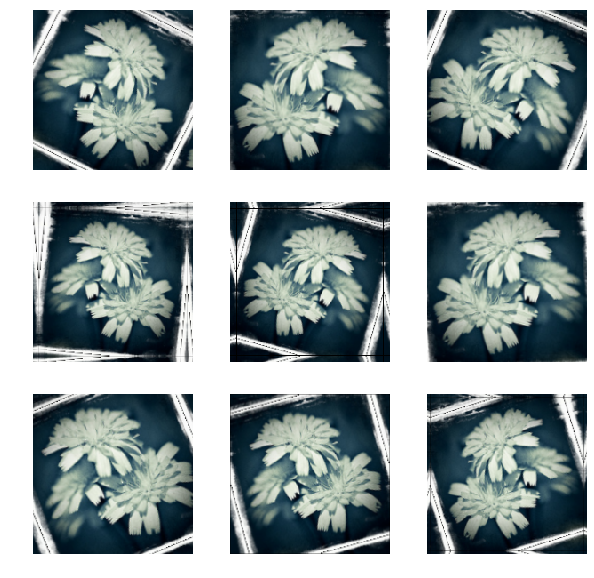

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1): # 拿一个batch进行测试
    # augmented_images = data_augmentation(images) # 位置不同效果不同
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Dropout
另外一个消除过拟合的技巧就是在网络结构中引入`Dropout`——一种正则化方式。

当你运用在layer中应用Dropout，它将在训练过程中从layer里随机的去除掉一些输出节点。Dropout接受一个小数作为它的输入参数，比如0.1、0.2、0.4等。这意味着从layer中剔除的神经节点个数占总节点数的10%、20%或40%。

接下来使用`layers.Dropout`创建一个新的网络结构：

In [35]:
# 新建模型
model = Sequential([
  data_augmentation, # 数据增广
  layers.experimental.preprocessing.Rescaling(1./255), # 数据归一化
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Dropout操作
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### 编译和训练模型

In [36]:
# 模型编译
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
# 模型概要
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [38]:
# 模型训练
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
184/184 [==============================] - 70s 378ms/step - loss: 1.2914 - accuracy: 0.4373 - val_accuracy: 0.5804 - val_loss: 1.0982
Epoch 2/15
184/184 [==============================] - 67s 364ms/step - loss: 1.0710 - accuracy: 0.5766 - val_accuracy: 0.6267 - val_loss: 0.9869
Epoch 3/15
184/184 [==============================] - 66s 360ms/step - loss: 0.9345 - accuracy: 0.6366 - val_accuracy: 0.6553 - val_loss: 0.8949
Epoch 4/15
184/184 [==============================] - 70s 378ms/step - loss: 0.8375 - accuracy: 0.6768 - val_accuracy: 0.7084 - val_loss: 0.8040
Epoch 5/15
184/184 [==============================] - 66s 360ms/step - loss: 0.8041 - accuracy: 0.6962 - val_accuracy: 0.6866 - val_loss: 0.8375
Epoch 6/15
184/184 [==============================] - 69s 373ms/step - loss: 0.7720 - accuracy: 0.7057 - val_accuracy: 0.6839 - val_loss: 0.8217
Epoch 7/15
184/184 [==============================] - 72s 391ms/step - loss: 0.7350 - accuracy: 0.7163 - val_accuracy: 0.6907 - va

#### 可视化训练结果
在应用了数据增加和删除后，过拟合比之前减少，训练和验证精度也更接近。

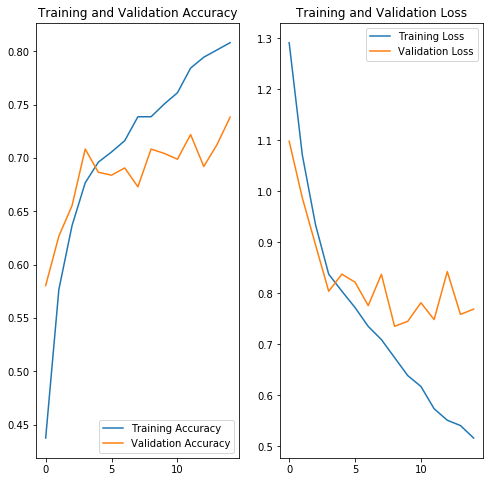

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 推理新数据
使用该模型推理未见过的新数据。

Note:数据增广和Dropout在推理时并不工作。

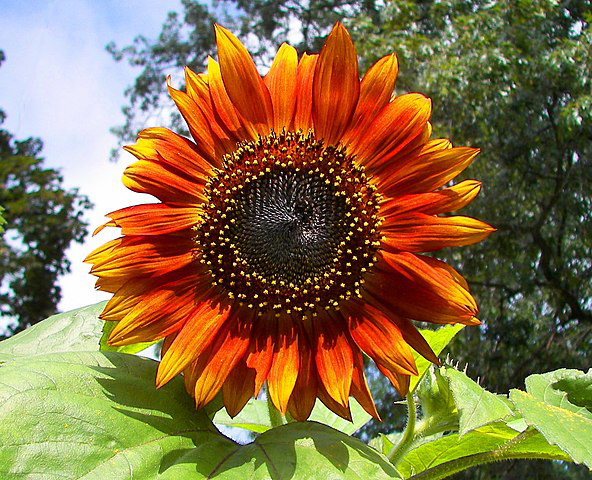

In [42]:
# 笔者将图片已经下载到./datasets/flower_photos/592px-Red_sunflower.jpg
sunflower_path = "./datasets/flower_photos/592px-Red_sunflower.jpg"
# 显示图片
PIL.Image.open(sunflower_path)

In [43]:
# 加载数据
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
# 将图片信息转为ndarray
img_array = keras.preprocessing.image.img_to_array(img)
# 产生一个batch
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0]) # 对结果打分

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.29 percent confidence.


In [29]:
# test code
x = np.arange(10).reshape(10,)
print(x)
l = [i for i in range(10)]
print(np.array(l).shape)

[0 1 2 3 4 5 6 7 8 9]
(10,)
